In [1]:
import numpy as np
import os
from glob import glob

In [2]:
path = 'DATA_CHAMBER_2021'

files_training = glob(os.path.join(path, 'train', '*/*.*'))
num_imgs = len(files_training)
print("Training images: ", num_imgs)

Training images:  6717


In [3]:
print("{:18s}".format('class'), end='')
print('count')
print('-'*22)

class_names=[]
for i, folder in enumerate(os.listdir(os.path.join(path, 'train'))):
    num = len(os.listdir(os.path.join(path, 'train', folder)))
    print('{:3d} {:20s}'.format(i, folder), end='')
    print(num)
    class_names.append(folder)
print("\n\nTotal class: ", len(class_names))

class             count
----------------------
  0 2C                  2377
  1 3C                  2309
  2 4C                  2031


Total class:  3


In [4]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder

tensor_transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor()
])

all_data = ImageFolder(os.path.join(path, 'train'), tensor_transform)

data_loader = torch.utils.data.DataLoader(all_data, batch_size=512, shuffle=True)

In [5]:
tol_mean = []
tol_std = []

for i, data in enumerate(data_loader):
    # tensor to numpy
    numpy_image = data[0].numpy()

    # compute mean and standard devation
    # axis=023 bcs data[0] size is (batchsize, channels, width, height)
    # so we want to compute mean and std of 3 channels
    batch_mean = np.mean(numpy_image, axis=(0,2,3))
    batch_std = np.std(numpy_image, axis=(0,2,3))

    tol_mean.append(batch_mean)
    tol_std.append(batch_std)
    
tol_mean = np.array(tol_mean).mean(axis=0)
tol_std = np.array(tol_std).mean(axis=0)
print(tol_mean)
print(tol_std)

[0.13285467 0.12805647 0.12908885]
[0.2061425  0.20130977 0.20254733]


In [6]:
tol_mean = [0.13285483, 0.12812747, 0.12914398]
tol_std = [0.20637107, 0.2016242,  0.20284693]

In [7]:
np.random.seed(0)
shuffle = np.random.permutation(num_imgs)
split_val = int(num_imgs*0.2)
print('Number of valid images after split:',len(shuffle[:split_val]))
print('Number of train images after split:',len(shuffle[split_val:]))

Number of valid images after split: 1343
Number of train images after split: 5374


In [8]:
np.array([files_training[i] for i in shuffle[split_val:]])[0].split('\\')

['DATA_CHAMBER_2021', 'train', '3C', '117_16.jpg']

In [9]:
from PIL import Image
from torch.utils.data import Dataset

class TrainDataset(Dataset):
    def __init__(self, files, shuffle, spilit_val, class_names, transform=transforms.ToTensor()):
        self.class_names = class_names
        self.transform = transform
        self.data = np.array([files[i] for i in shuffle[spilit_val:]])
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img = Image.open(self.data[idx])
        img = self.transform(img)
        name = self.data[idx].split('\\')[-2]
        y = self.class_names.index(name)
        return img, y

class ValidDataset(Dataset):
    def __init__(self, files, shuffle, spilit_val, class_names, transform=transforms.ToTensor()):
        self.class_names = class_names
        self.transform = transform
        self.data = np.array([files[i] for i in shuffle[:spilit_val]])
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img = Image.open(self.data[idx])
        img = self.transform(img)
        name = self.data[idx].split('\\')[-2]
        y = self.class_names.index(name) 
        return img, y

class TestDataset(Dataset):
    def __init__(self, path, class_names, transform=transforms.ToTensor()):
        self.class_names = class_names
        self.transform = transform
        self.data = np.array(glob(os.path.join(path, 'test', '*/*.*')))
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img = Image.open(self.data[idx])
        img = self.transform(img)
        name = self.data[idx].split('\\')[-2]
        y = self.class_names.index(name)
        return img, y

In [10]:
data_transform = {
    'train' : transforms.Compose([
        transforms.Resize((100, 100)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(tol_mean, tol_std)
    ]),
    'valid' : transforms.Compose([
        transforms.Resize((100, 100)),
        transforms.ToTensor(),
        transforms.Normalize(tol_mean, tol_std)
    ]),
    'test' : transforms.Compose([
        transforms.Resize((100, 100)),
        transforms.ToTensor(),
        transforms.Normalize(tol_mean, tol_std)

    ])
}
test_dataset = TestDataset(path, class_names, data_transform['test'])
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

In [11]:
train_dataset = TrainDataset(files_training, shuffle, 
                                split_val, class_names, data_transform['train'])
valid_dataset = ValidDataset(files_training, shuffle,
                                split_val, class_names, data_transform['valid'])
test_dataset = TestDataset(path, class_names, data_transform['test'])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

In [12]:
dataloader = {
    'train' : train_loader,
    'valid' : valid_loader,
    'test' : test_loader
}

dataset = {
    'train' : train_dataset,
    'valid' : valid_dataset,
    'test' : test_dataset
}

(100, 100, 3)


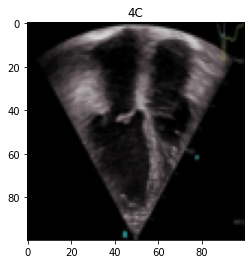

In [14]:
import matplotlib.pyplot as plt

for images, labels in train_loader:
    images = images.numpy()
    temp = images[0].transpose((1,2,0))
    print(temp.shape)
    temp = temp * tol_std + tol_mean
    temp = np.clip(temp, 0, 1)
    plt.imshow(temp)
    plt.title(class_names[labels.numpy()[0]])
    break
    

In [15]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5)
        self.conv1_bn = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.conv2_bn = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv3_bn = nn.BatchNorm2d(64)

        self.fc1 = nn.Linear(64 * 10 * 10, 250)
        self.fc2 = nn.Linear(250, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1_bn(self.conv1(x))))
        x = self.pool(F.relu(self.conv2_bn(self.conv2(x))))
        x = self.pool(F.relu(self.conv3_bn(self.conv3(x))))
        x = x.view(-1, 64 * 10 * 10)
        x = F.dropout(F.relu(self.fc1(x)), p=0.4)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)

In [16]:
import torch.optim as optim

# device = torch.device("cuda:0")
model = Net(len(class_names))
# model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
exp_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
# lr = lr/0.1 for each 7 epoch


In [18]:
dataloader = {
    'train' : train_loader,
    'valid' : valid_loader,
    'test' : test_loader
}

dataset = {
    'train' : train_dataset,
    'valid' : valid_dataset,
    'test' : test_dataset
}

import time
import copy

def fit(model, criterion, optimizer, scheduler, num_epochs=30):

    history = {
        'train': list(),
        'valid': list()
    }

    history_acc = {
        'train': list(),
        'valid': list()
    }

    begin = time.time()
    best_acc = 0.0
    for epoch in range(num_epochs):
        print("\nEpoch {}/{}:".format(epoch, num_epochs-1))

        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train() # enable dropout & batchnorm
            else:
                model.eval() # disable dropout & batchnorm

            running_loss = 0.0
            running_acc = 0
            for inputs, labels in dataloader[phase]:
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    # max with dim=1, return: value & index
                    # just need index to compare with labels

                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_acc += torch.sum(preds == labels)

            phase_loss = running_loss / len(dataset[phase])
            history[phase].append(phase_loss)
            phase_acc = running_acc / len(dataset[phase])
            history_acc[phase].append(float(phase_acc))

            print("{} Loss: {:4f} Accuracy: {:4f}".format(phase, phase_loss, phase_acc))

            if phase == 'valid' and phase_acc > best_acc:
                best_acc = phase_acc
                best_model = copy.deepcopy(model.state_dict())

    end = time.time() - begin
    h = end//3600
    m = (end - h*3600)//60
    print("\nComplete training in {:.0f}h {:.0f}m".format(h, m))

    import json

    history_file = open('history_acc.json', "w")
    json.dump(history_acc, history_file)
    history_file.close()

    history_file = open('history.json', "w")
    json.dump(history, history_file)
    history_file.close()
    
    model.load_state_dict(best_model)
    return model
                
model = fit(model, criterion, optimizer, exp_scheduler, num_epochs=30)


Epoch 0/29:
train Loss: 0.909924 Accuracy: 0.587086
valid Loss: 0.796709 Accuracy: 0.663440

Epoch 1/29:
train Loss: 0.684864 Accuracy: 0.718273
valid Loss: 0.668976 Accuracy: 0.727476

Epoch 2/29:
train Loss: 0.524868 Accuracy: 0.802940
valid Loss: 0.588710 Accuracy: 0.728220

Epoch 3/29:
train Loss: 0.387689 Accuracy: 0.862486
valid Loss: 0.333137 Accuracy: 0.903202

Epoch 4/29:
train Loss: 0.287228 Accuracy: 0.911053
valid Loss: 0.282793 Accuracy: 0.917349

Epoch 5/29:
train Loss: 0.207024 Accuracy: 0.950502
valid Loss: 0.216073 Accuracy: 0.954579

Epoch 6/29:
train Loss: 0.193467 Accuracy: 0.956829
valid Loss: 0.196668 Accuracy: 0.950856

Epoch 7/29:
train Loss: 0.186604 Accuracy: 0.957015
valid Loss: 0.196192 Accuracy: 0.957558

Epoch 8/29:
train Loss: 0.185243 Accuracy: 0.955713
valid Loss: 0.191430 Accuracy: 0.954579

Epoch 9/29:
train Loss: 0.175095 Accuracy: 0.963900
valid Loss: 0.181794 Accuracy: 0.960536

Epoch 10/29:
train Loss: 0.166966 Accuracy: 0.962970
valid Loss: 0.17

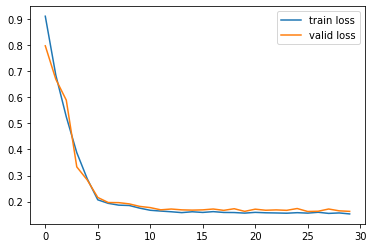

In [19]:
import json

history_path = 'history.json'

history_file = open(history_path, "r")
history = history_file.read()
history_file.close()

history = json.loads(history)

import matplotlib.pyplot as plt
plt.plot(history['train'])
plt.plot(history['valid'])
plt.legend(['train loss', 'valid loss'])
plt.show()

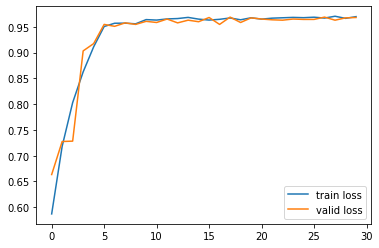

In [20]:
import json

history_path = 'history_acc.json'

history_file = open(history_path, "r")
history = history_file.read()
history_file.close()

history = json.loads(history)

import matplotlib.pyplot as plt
plt.plot(history['train'])
plt.plot(history['valid'])
plt.legend(['train loss', 'valid loss'])
plt.show()

In [23]:
correct = 0

with torch.no_grad():
    for inputs, labels in dataloader['test']:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels)
        print(preds)
    print("Accuracy on {} images: {:.4f}%".format(len(dataset['test']), 
                                                correct.double()/len(dataset['test']) * 100))

tensor([0, 1, 0, 0, 2, 0, 2, 2, 2, 0, 1, 1, 2, 0, 0, 2, 0, 1, 2, 1, 1, 1, 0, 2,
        0, 2, 1, 2, 0, 2, 2, 2, 0, 2, 2, 0, 2, 1, 1, 2, 2, 1, 1, 2, 1, 0, 0, 1,
        0, 1, 2, 0, 2, 0, 0, 0, 2, 1, 0, 1, 2, 2, 2, 0])
tensor([2, 0, 2, 2, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 2, 2, 1, 1, 0, 0, 2, 0, 1, 1,
        2, 2, 1, 2, 1, 2, 0, 0, 1, 2, 1, 1, 2, 2, 1, 0, 0, 1, 0, 2, 0, 0, 0, 2,
        1, 0, 1, 2, 2, 2, 0, 1, 1, 2, 1, 2, 0, 2, 0, 2])
tensor([0, 1, 0, 1, 2, 1, 2, 1, 1, 2, 0, 1, 1, 0, 0, 1, 2, 0, 2, 0, 0, 1, 2, 1,
        1, 0, 1, 2, 0, 1, 1, 0, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1,
        0, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 0, 2, 2, 2, 1])
tensor([2, 0, 2, 1, 2, 1, 0, 1, 2, 1, 0, 1, 0, 2, 2, 1, 0, 1, 2, 2, 2, 0, 2, 0,
        0, 0, 1, 1, 0, 0, 2, 2, 2, 1, 1, 1, 2, 2, 0, 0, 1, 1, 0, 1, 2, 2, 1, 0,
        0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 1, 1, 1, 0, 2, 0])
tensor([1, 2, 0, 1, 1, 1, 0, 2, 1, 0, 0, 0, 0, 2, 1, 1, 0, 2, 1, 1, 0, 2, 0, 1,
        1, 0, 2, 1, 1, 0, 1, 0, 2, 2, 0, 1, 2, 1, 2,

In [51]:
PATH = 'model.pt'
torch.save(model, PATH)

In [52]:
PATH = "state_dict_model.pt"
torch.save(model.state_dict(), PATH)

In [ ]:
import torch
from torchvision import transforms
from PIL import Image


model = Net(2)
model.load_state_dict(torch.load('state_dict_model.pt'))
model.eval()

img_path = '158_0.jpg'
image = Image.open(img_path)
image = image.view(1, 3, 100, 100)
tol_mean = [0.13285483, 0.12812747, 0.12914398]
tol_std = [0.20637107, 0.2016242,  0.20284693]

transform = transforms.Compose([transforms.Resize((100, 100)),
                                transforms.ToTensor(),
                                transforms.Normalize(tol_mean, tol_std)
                                ])
image = transform(image)
image = image.unsqueeze(0)

val, pred = torch.max(model(image), 1)
print(val)
print(pred.item())
print(class_names[pred.item()])